In [5]:
import numpy as np
import sys 
import os
sys.path.append('/home/giorgiod/Documents/APDFT/dep')
sys.path.append('/home/giorgiod/Documents/APDFT/src')

In [6]:
from apdft import Calculator

In [7]:
calc_path = '/home/giorgiod/MRCC_interface/Diatomics/from_co_opt_ccsd_ccpvtz_68_to_77_A5_G5/A_2_G_0/'
proj_path= '/home/giorgiod/MRCC_interface/Diatomics/from_co_opt_ccsd_ccpvtz_68_to_77_A5_G5/'
grid = Calculator.MrccCalculator.get_grid(None, None, calc_path)

In [8]:
ccdensity = Calculator.MrccCalculator.density_on_grid(calc_path + 'DENSITY', grid[0])

In [9]:
(ccdensity * grid[1]).sum()

13.999997492775165

In [10]:
Calculator.MrccCalculator.get_total_energy(calc_path)

{"filename": "/home/giorgiod/MRCC_interface/Diatomics/from_co_opt_ccsd_ccpvtz_68_to_77_A5_G5/A_2_G_0//run.log", "level": "error", "event": "Unable to read energy from log file.", "timestamp": "2019-06-17 09:52"}


0

In [11]:
def parse_energy_cc(log_file):
    """Parse the couple cluster energy from an MRCC output file"""
    with open(log_file,'r') as logf:
        while True:
            line=logf.readline()
            if "Final results:" in line:
                good_line=logf.readline()
                if "Total CCSD energy" in good_line:
                    for x in good_line.split(' '):
                        try:
                            float(x)
                            return (float(x))
                        except:
                            pass    

In [12]:
gl=Calculator.MrccCalculator.parse_energy_cc_Mrcc(calc_path+'/run.log')
print(gl)

-113.952850161528


In [13]:
from apdft.physics import Coulomb

In [14]:
def get_energy(proj_path,ao,go):
    return (parse_energy_cc("{}A_{}_G_{}/run.log".format(proj_path,ao,go)))

In [15]:
not 'Schetch_MRCC_readfiles.ipynb' in os.listdir('.')

False

In [16]:
get_energy(proj_path,2,1)

-113.952527910755

In [17]:
dX= 0.03779452267842504  # bohrs 
dXa=.02               # angstroms
dL=0.05  ## delta Lambda = 0.05

In [18]:
k= (get_energy(proj_path,0,1)+get_energy(proj_path,0,-1)-2*get_energy(proj_path,0,0))/dX**2

In [19]:
#### constants #####
angstorm=1.889726133921252
N_mass=25532.936684486547
centimeter=188972613.39212522
light_speed= 137.03599975303575
C_mass=21893.98614768941
O_mass=29165.124304476205
mu_nn=N_mass/2
mu_co=C_mass*O_mass/(C_mass+O_mass)

In [20]:
def to_cm(k,mu=mu_co):
    return (k/mu)**0.5*centimeter/light_speed/(2*np.pi)

In [21]:
to_cm(k) ### ok good job

2241.120735039024

In [22]:
def common_grid(go):
    return (Calculator.MrccCalculator.get_grid(None, None, proj_path+'A_0_G_{}/'.format(go)))

In [23]:
print (type(common_grid(1)))
common_grid(1)[0].shape, common_grid(0)[1].shape #grid=(array[[x0,y0,z0],...,[xN,yN,zN]], array[w0,...wN])

<class 'tuple'>


((58072, 3), (58060,))

In [24]:
####### alchemy expantion ####  COMMON_GRID IS TO BE DEFINED FOR EACH GEOMETRY  
def get_ccdensity(ao,go):
    return Calculator.MrccCalculator.density_on_grid("{}A_{}_G_{}/DENSITY".format(proj_path,ao,go),common_grid(go)[0])

In [25]:
get_ccdensity(-2,-2)-get_ccdensity(2,-2)

array([2.94618559e-22, 3.79179046e-22, 5.17586133e-22, ...,
       6.34885971e-27, 3.95003423e-27, 2.96783422e-27])

In [26]:
get_energy(proj_path,0,1)

-113.162330773499

In [27]:
from apdft.physics import Coulomb

In [28]:
### very poor code 
co_minR=1.125614241653 # angstrom
atoms=np.asarray([6.,8.])
def coordinates(go): ### angstrom 
    return np.asarray([[0.,0.,0.],[ co_minR+go*dXa,0.,0.]])
target=np.asarray([7.,7.])

In [29]:
print(Coulomb.nuclei_nuclei(coordinates(0),atoms)/48)
print(Coulomb.nuclei_nuclei(coordinates(0),target)/49)

0.4701230591156049
0.4701230591156049


In [30]:
from apdft.physics import angstrom
angstrom


1.8897261254578281

In [31]:
def deltaV(go):
    ds = []
    for site in coordinates(go):
        ds.append(np.linalg.norm((common_grid(go)[0] - site*angstrom),axis=1))
                #  grid, coordinates in angstrom * 1.88 -> bohr (au) for Hamiltonian calcs.
    deltaV = np.zeros(len(common_grid(go)[1]))
    for atomidx in range(len(atoms)):
        deltaV += (target[atomidx]-atoms[atomidx]) / ds[atomidx]
    return (deltaV)

$\tilde{\rho} = \rho^0 +\frac{1}{2}\rho' +\frac{1}{6}\rho " + \frac{1}{24}\rho ^{(3)}+ \frac{1}{120}\rho ^{(4)} $ 

## 5point coefficients <br>
0  :      0    :  1    :  0   :     0  <br>
1/12 :	−2/3 :	0 	 : 2/3 :	−1/12    for first deriv <br>
−1/12 :	4/3 :	−5/2 : 4/3 : −1/12  for second deriv <br>
−1/2 :	 1 	:    0 	:  −1    :  1/2   for third deriv <br>
 1  :	−4  :	6 	:  −4   : 1       for fourth deriv <br>
 
 

In [32]:
coeff0=np.asarray([0,0,1,0,0])
coeff1=np.asarray([1/12,-2/3,0,2/3,-1/12])
coeff2=np.asarray([-1/12 , 4/3 , -5/2 , 4/3 , -1/12])
coeff3=np.asarray([-1/2 , 1 , 0 , -1 , 1/2])
coeff4=np.asarray([1 ,-4 , 6 ,-4 , 1])
coeff_tilda=coeff0+1/2*coeff1/dL+1/6*coeff2/dL**2+1/24*coeff3/dL**3+1/120*coeff4/dL**4
print (coeff_tilda, np.sum(coeff_tilda))
coeff_taylor=coeff0+coeff1+1/2*coeff2+1/26*coeff3+1/24*coeff4
print (coeff_taylor, np.sum(coeff_taylor))

[ 1161.94444444 -4917.77777778  7834.33333333 -5571.11111111
  1493.61111111] 1.0000000000013642
[ 0.06410256 -0.12820513  0.          1.12820513 -0.06410256] 0.9999999999999998


In [33]:
def rho_tilda(go):
    rho_tilda=np.zeros(len(common_grid(go)[1]))
    for x in range(5):
        rho_tilda+=get_ccdensity(2-x,go)*coeff_tilda[x]    ### note error in defining alchemy order 
    return rho_tilda

In [46]:
Coulomb.nuclei_nuclei(coordinates(0),atoms)

22.565906837549036

In [60]:
def alchem_predict(go):
    energy=get_energy(proj_path,0,go)
    energy+=np.sum(-deltaV(go)*rho_tilda(go)*common_grid(go)[1])
    energy-=Coulomb.nuclei_nuclei(coordinates(go),atoms)
    energy+=Coulomb.nuclei_nuclei(coordinates(go),target)
    return (energy)

In [48]:
import matplotlib.pyplot as plt

[-109.37076052389287, -109.3541816490978, -109.33566996290725, -109.31553093148318, -109.29404556256614]


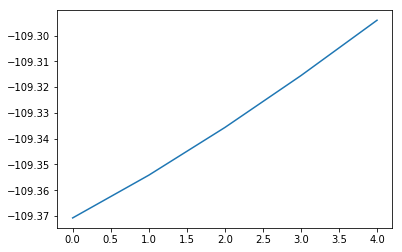

[-113.159133929181, -113.162244682358, -113.163219060971, -113.162330773499, -113.159822974319]


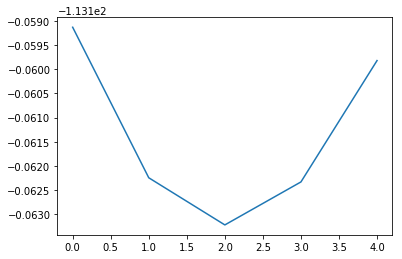

In [49]:
alchem_points=[]
for i in range(5):
    alchem_points.append (alchem_predict(i-2))
plt.plot(alchem_points)
print (alchem_points)
plt.show()
ref_points=[]
for i in range(5):
    ref_points.append(get_energy(proj_path,0,i-2))
plt.plot(ref_points)
print(ref_points)
plt.show()


In [54]:
def FivePointDerivatives(points,h):
   # the finite difference calculated derivatives
    fd4=(points[4]-points[3]*4+points[2]*6-points[1]*4+points[0])/h**4
    fd3=(points[4]-2*points[3]+2*points[1]-points[0])/(2*h**3)
    fd1=(points[3]-points[1]-h**3*fd3/3.)/2/h
    fd2=(points[3]-2*points[2]+points[1]-h**4/12.*fd4)/(h**2)
    return [fd1,fd2,fd3,fd4]

In [55]:
derivs=FivePointDerivatives(alchem_points,dX)
print (derivs,to_cm(derivs[1],mu_nn))

# co_energy=[]
# for x in range(5):
#     co_energy.append(get_energy(proj_path,0,x-2))
# print(FivePointDerivatives(co_energy,dX))
# print (to_cm(FivePointDerivatives(co_energy,dX)[1],mu_co),co_energy)

[0.5126200904126218, 1.1378307976008875, -5.4316540466038425, 11.987067856874305] 2071.9906164010417


In [52]:
def dx4f2(x,e,d1,d2,d3,d4):
    a=d4/6.
    b=d3/2.
    c=d2
    d=d1
    D0=b**2-3*a*c
    D1=2*b**3-9*a*b*c+27*a**2*d
    C=((D1+(D1**2-4*D0**3)**0.5)/2.)**(1/3.)
    dx=-(b+C+D0/C)/(3.*a)
    p2d=d2+dx*d3+0.5*d4*dx**2
    return x+dx, to_cm(p2d,mu_nn), x
def dx2f1(x,e,d1,d2,d3,d4):
    dx=-d1/d2
    p2d=d2+dx*d3
    return (x+dx,to_cm(p2d,mu_nn))

In [53]:
print(dx4f2(coordinates(0)[1][0]*angstrom,alchem_predict(0),*derivs))
print(dx2f1(coordinates(0)[1][0]*angstrom,alchem_predict(0),*derivs))

(1.8677529281547756, 3336.072404097062, 2.127102639639075)
(1.6765786324725616, 3677.8054974298925)


In [56]:
print (np.asarray([1.92,1.97,2.02])/angstrom)


[1.01602024 1.04247911 1.06893797]


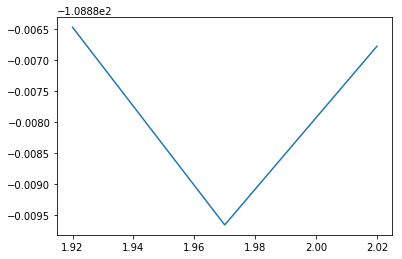

In [57]:
targetPes=[[1.92,  -108.886468439106],[1.97,-108.889655736097],[2.02,-108.886775641668]]
plt.plot([x[0] for x in targetPes],[x[1] for x in targetPes])

In [58]:
Ktp=(targetPes[2][1]+targetPes[0][1]-2*targetPes[1][1])/0.05**2

In [59]:
print (to_cm(Ktp,mu_nn))

3026.0767874056164
